In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats.mixed_effects import MixedEffects
from hb_mep.models.rats.utils import load_data
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

""" Load """
dir_name = "physio2"
participants = range(1, 7)
dir = os.path.join(data.data_path, dir_name)

df, mat, time = load_data(dir=dir)

""" Filter: Ground Screw """
idx = df.channel1_segment.isna()

df = df[idx].copy()
mat = mat[idx, :, :]

""" Preprocess """
df, encoder_dict = data.build(df)

mat = mat[:, :, 0]


2023-06-14 09:26:17,613 - hb_mep.utils.utils - INFO - func:load_data took: 0.98 sec
2023-06-14 09:26:17,639 - hb_mep.data_access.core - INFO - Processing data ...
2023-06-14 09:26:17,651 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-06-14 09:26:17,652 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


#### Plot

In [5]:
# plot(df=df, encoder_dict=encoder_dict, mat=mat, time=time);

#### Initialize model

In [6]:
model = MixedEffects(config)

2023-06-13 11:39:04,218 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-06-13 11:39:04,219 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-13 11:39:04,219 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-13 11:39:04,220 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-06-13 11:39:04,220 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-06-13 11:39:04,314 - hb_mep.models.rats.mixed_effects - INFO - Running inference with Mixed_Effects ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-13 12:10:48,201 - hb_mep.utils.utils - INFO - func:run_inference took: 31 min and 43.89 sec


#### Diagnostics

In [8]:
mcmc.print_summary(prob=.95)


                               mean       std    median      2.5%     97.5%     n_eff     r_hat
                 a[0,0,0]    123.71      2.88    123.87    117.61    129.09  20244.66      1.00
                 a[0,0,1]     45.36      1.75     45.55     41.79     48.13  13379.17      1.00
                 a[0,0,2]     41.18      1.92     41.49     37.09     44.22  15724.23      1.00
                 a[0,0,3]     13.31      4.46     13.94      2.53     20.56   4257.37      1.00
                 a[0,0,4]     29.41      1.92     29.35     25.85     33.93   8575.25      1.00
                 a[0,0,5]     70.11      4.32     70.02     61.83     78.13  13658.69      1.00
                 a[0,1,0]    128.55      2.36    128.67    123.84    132.81  16928.87      1.00
                 a[0,1,1]    119.31      3.39    119.63    112.33    125.39  16031.99      1.00
                 a[0,1,2]    110.11      4.27    110.42    100.53    117.27   8707.71      1.00
                 a[0,1,3]     26.66    

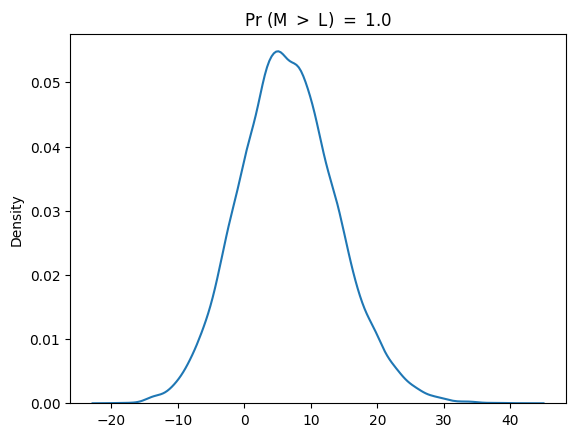

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

m0, m1 = encoder_dict["method"].inverse_transform(np.array([0, 1]))

delta = posterior_samples["delta"]
samples = delta.mean(axis=-1)

sns.kdeplot(samples)
plt.title(f"Pr ({m1} $>$ {m0}) $=$ {(samples.mean() > 1).mean()}");

In [16]:
delta.shape

(24000, 24)

(24000,)

<Axes: ylabel='Density'>

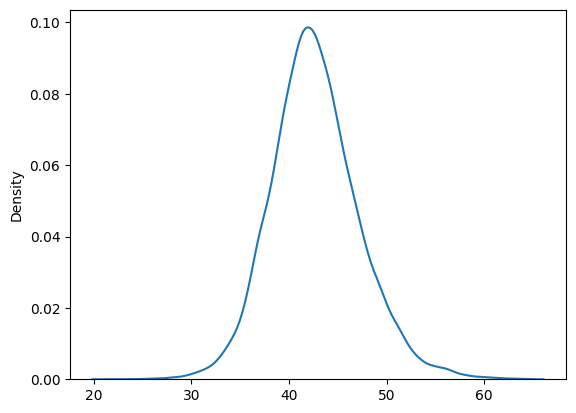

In [19]:
samples = delta[:, 0]

sns.kdeplot(samples)

In [ ]:
delta = posterior_samples["delta"]
samples = delta.mean(axis=-1)


#### Plot fitted curves

2023-06-13 12:21:32,481 - hb_mep.utils.utils - INFO - func:plot took: 10 min and 41.89 sec


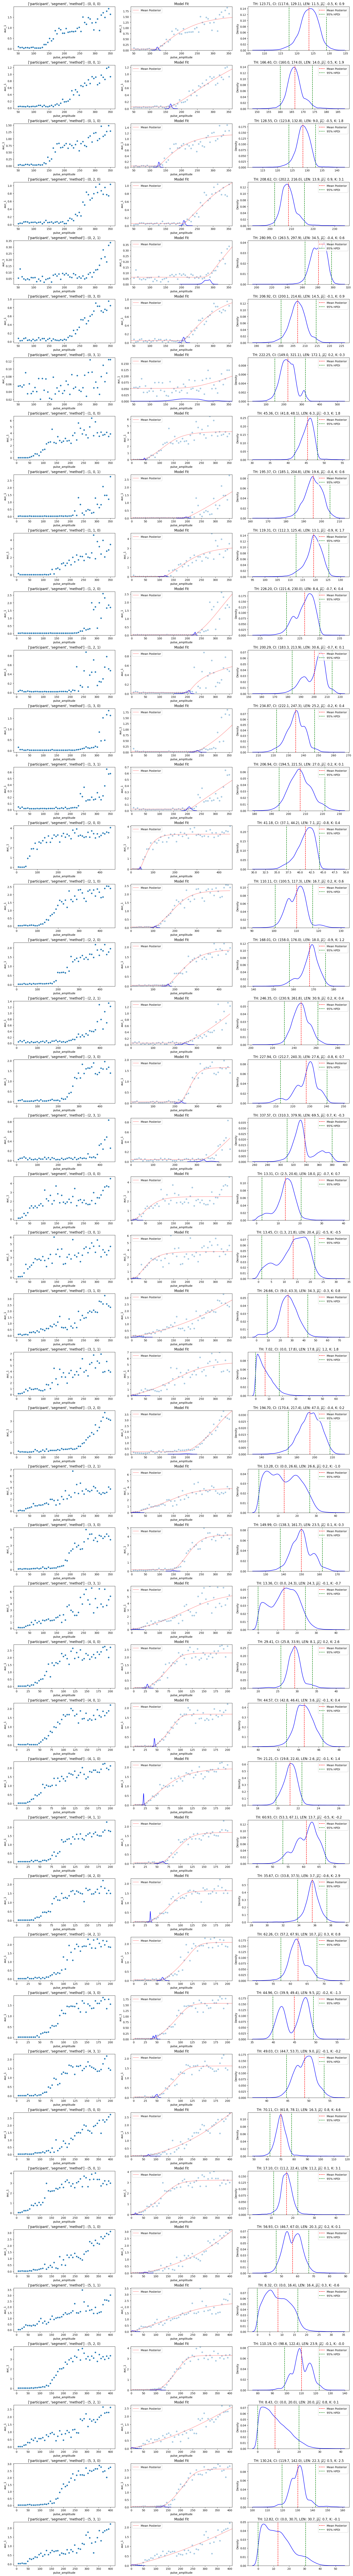

In [12]:
model.plot(df=df, posterior_samples=posterior_samples);